# Time Series Forecasting Flu Patterns in the U.S. (2015-2020)
### Andy Nguyen, Michael Wolfe, Joseph Caguioa
### 6/24/20

## Objective
Time series data consists of a ordinal sequence of values collected at successive equally spaced points in time. In contrast to cross-sectional data in which information is collected at a single point in time, time series data can be indexed by the date or time when the information was collected. The goals of time series analysis are typically to determine trends or patterns of the collected data over time and building models to forecast future behavior within confidence limits.

Due to the uncertainty and unpredictable nature of time series (such as stock data), providing confidence limits for forecasted predictions are vital in capturing the viability of models. As with predicting continuous-scaled variables, forecasts accompanied with confidence intervals provide a range of values that the model deems plausible based on the patterns and trends accounted for in the time series.

Long-term time series forecast extending a few years into the future present a tough challenge as they are often imprecise and unreliable since models are only designed to best describe the provided data. Horizons (forecast window n-time points in the future) extending far into the future tend to compound the issues of uncertainty and volatility associated with time series data. Depending on the models used, forecasts may begin to regress towards the mean or continue predicting trends even when not present with large horizons.

The objective of this analysis will be to determine trends and patterns in influenza activity within the United States at a national level over the past 5 years. An auto-regressive integrated moving average (ARIMA) model will then be implemented to forecast future flu cases based on the trends and patterns observed in the time series from 2015-2020. A forecast horizon of only 3 months (12 weeks) into the future will be provided to avoid the challenges associated with long-term forecasts.


## Data Description

<figure class ="image">
<center>
    <img src = "FluView.png">
    <figcaption id = "Figure 1"> Figure 1: Weekly U.S. Influenza Surveillance System </figcaption>
</center>
</figure>

The time series data is obtained from the weekly FluView surveillance report dating back to the 1997-1998 flu season, but only a subset of the data starting in October 2015 to June 2020 will be used in this analysis to capture the most recent trends in influenza activity. These weekly reports are compiled by the CDC to analyze flu activity year round in the United States. Specific details on the data collection methods and purposes of FluView are provided at the following link: https://www.cdc.gov/flu/weekly/overview.htm. 

The surveillance system compiles data from both clinical and public health laboratories. The data used in this analysis is the portion of positive influenza tests reported by U.S. public health laboratories at the national level from 10/4/15 - 6/14/20. In addition to the total number of flu specimens reported in a week, the data set provides specific influenza subtypes and lineages: A (2009 H1N1), A (H3), A (Subtyping not Performed), B, BVic, BYam, and H3N2v. The scope of this analysis will only focus on the total number of flu specimens as a time series so these specific subtypes and lineages will be omitted from this study. However, more in-depth analyses can be conducted using these subtypes and lineages to monitor the proportion of circulating influenza virus types.

In [77]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import FileLink, FileLinks

In [7]:
rawflu2015 = pd.read_csv('Data/WHO_NREVSS_Public_Health_Labs.csv', sep=',', header=0, skiprows=1)
rawflu2015

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,A (2009 H1N1),A (H3),A (Subtyping not Performed),B,BVic,BYam,H3N2v
0,National,X,2015,40,1139,4,65,2,10,0,1,0
1,National,X,2015,41,1152,5,41,2,7,3,0,0
2,National,X,2015,42,1198,10,50,1,8,3,2,0
3,National,X,2015,43,1244,9,31,4,9,1,4,0
4,National,X,2015,44,1465,4,23,4,9,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
241,National,X,2020,21,536,0,0,1,0,0,0,0
242,National,X,2020,22,515,2,0,1,1,0,0,0
243,National,X,2020,23,322,0,0,0,1,0,0,0
244,National,X,2020,24,305,0,0,0,1,0,0,0


As previously mentioned, the time series will be analyzed at the national level so the Region Type and Region variables are irrelevant and will be removed in processing the data. The date in which reports were compiled (Year and Week) will be used as the date index of the processed FluCases data frame. The processed time series data for total flu cases contains a total of 246 weekly reports from October 2015 to June 2020.

In [9]:
date_index = pd.date_range(start="2015-10-4", end="2020-6-14", freq='W-SUN')
TS = pd.DataFrame(rawflu2015['TOTAL SPECIMENS'])
FluCases2015 = TS.set_index(date_index)
FluCases2015

,TOTAL SPECIMENS
2015-10-04,1139
2015-10-11,1152
2015-10-18,1198
2015-10-25,1244
2015-11-01,1465
...,...
2020-05-17,536
2020-05-24,515
2020-05-31,322
2020-06-07,305


## Exploratory Data Analysis

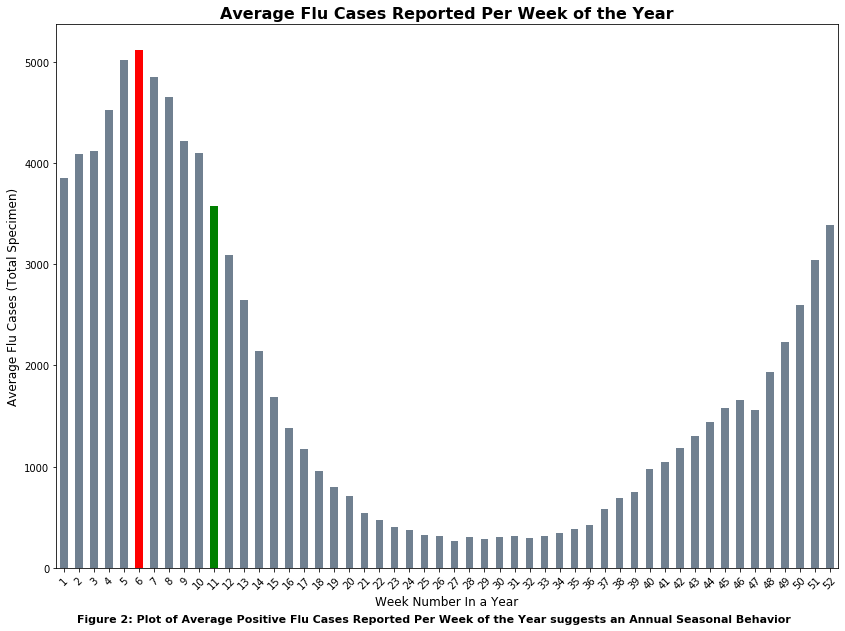

In [71]:
fig2 = plt.figure()
wAgg_ax = WeekAggregate2015.plot(kind='bar', color='slategrey', figsize=(14,10))
plt.title('Average Flu Cases Reported Per Week of the Year', fontsize=16, weight='bold')
wAgg_ax.set_xlabel("Week Number In a Year", fontsize=12)
wAgg_ax.set_ylabel("Average Flu Cases (Total Specimen)", fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(rotation=45, fontsize=10)
highlightG = 11
highlightR = 6
posG = WeekAggregate2015.index.get_loc(highlightG)
posR = WeekAggregate2015.index.get_loc(highlightR)
wAgg_ax.patches[posG].set_facecolor('green')
wAgg_ax.patches[posR].set_facecolor('red')
caption2 = "Figure 2: Plot of Average Positive Flu Cases Reported Per Week of the Year suggests an Annual Seasonal Behavior"
plt.figtext(0.5, 0.05, caption, ha='center', weight='bold',fontsize=11)
plt.show()

Aggregating the data by weeks in the year, Figure 2 shows that flu activity begins to increase towards the end of the year (weeks 48-52) and peak on the 6th week of the year or around the middle of February (higlighted in red). Activity begins to fall off again roughly around the 11th week or the end of March (highlighted in green). This suggests that these trends in flu activity over the past 5 years follow a seasonal behavior that cycles annually.

### Stationarity Exploration

Forecasting methods for time series are typically based on parametric assumptions in which the statistical properties (mean, variance, autocorrelation) of the data are constant over time. Satisfying these constant parametric assumptions indicate a stationary time series that yields stable predictions since these statistical properties are assumed to be the same in future forecasts as in the provided time series (past realizations). If these conditions are not met, it is difficult to extrapolate model conclusions into the future because the statistics defining the current time series data can not be used to describe future behavior.

<Figure size 432x288 with 0 Axes>

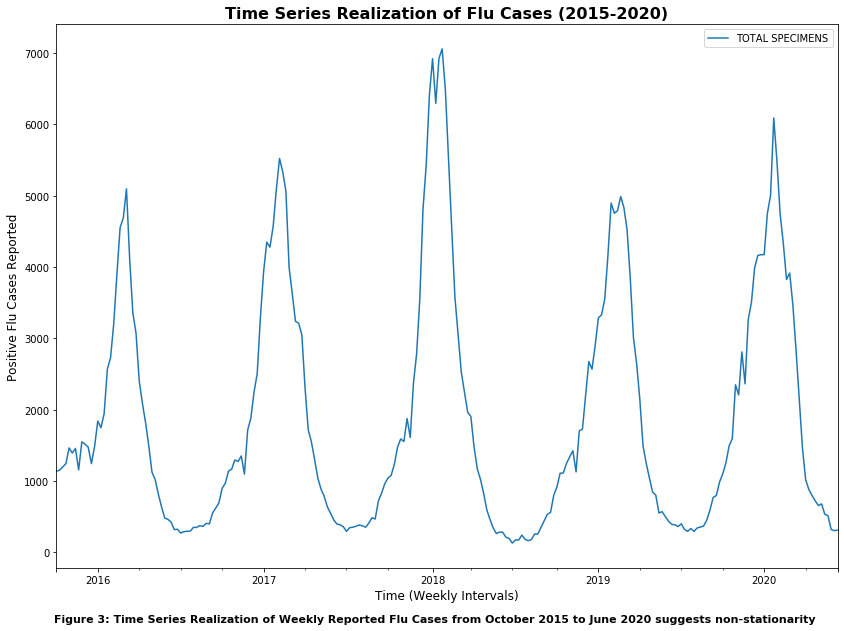

In [72]:
fig3 = plt.figure()
TS_realization = FluCases2015.plot(figsize=(14,10))
plt.title('Time Series Realization of Flu Cases (2015-2020)', fontsize=16, weight='bold')
TS_realization.set_xlabel("Time (Weekly Intervals)", fontsize=12)
TS_realization.set_ylabel("Positive Flu Cases Reported", fontsize=12)
caption3 = "Figure 3: Time Series Realization of Weekly Reported Flu Cases from October 2015 to June 2020 suggests non-stationarity"
plt.figtext(0.5, 0.05, caption3, ha='center', weight='bold',fontsize=11)
plt.show()

Figure 3 shows the realization of the flu activity time series with clear peaks repeating around the beginning of every year, suggesting an annaul trend in the data that is consistent with the fact that influenza viruses typically circulate every year. We suspect the seasonal trend in the data with will be a factor of s=52 weeks (~1 year). This observed seasonality seen with the peaks repeating every year indicate that the mean depends on time and is not constant throughout the time series. Due to this violation, we suspect that time series comes from a **non-stationary process**.

Assessing the constant variance assumption over time, the peaks all appear to be approximately the same size despite the pronounced peak at the beginning of 2018. There is some evidence to suggest that the variances do not depend on time, but this is a questional assumption because we can not assume that the mean is constant throughout the time series.

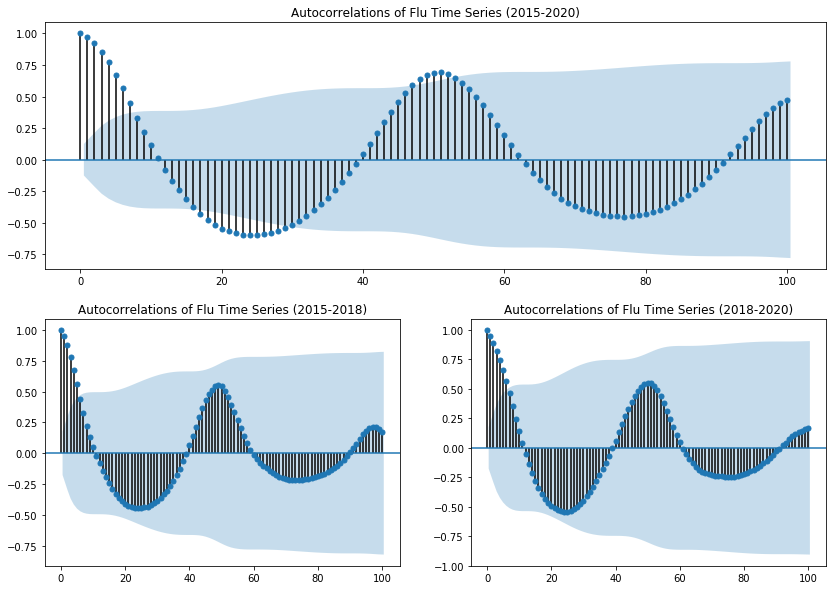

In [88]:
gs = gridspec.GridSpec(2,2)
fig4 = plt.figure(figsize=(14,10))
ax1 = fig4.add_subplot(gs[0,:])
plot_acf(FluCases2015, lags=100, title="Autocorrelations of Flu Time Series (2015-2020)", ax=ax1)
ax2 = fig4.add_subplot(gs[1,0])
plot_acf(FluCases2015[0:123], lags=100, title="Autocorrelations of Flu Time Series (2015-2018)", ax=ax2)
ax3 = fig4.add_subplot(gs[1,1])
plot_acf(FluCases2015[123:246], lags=100, title="Autocorrelations of Flu Time Series (2018-2020)", ax=ax3)
plt.show()

The simple check of the autocorrelations of the first and second half of the time series data seem to resemble one another as well as the ACF of the full time series. This provides evidence that the correlations of data points only depend on how far apart they are and not on where they are at in time.

The autocorrelation function of the flu data exhibits a dampening sinusoidal pattern with a period of as shown with the apex of the curve repeating roughly at every 50 lags. This provides further evidence of annual seasonality with every data point roughly 52 weeks apart displaying high correlation.

In [86]:
from statsmodels.tsa.stattools import acf
acf(FluCases2015,nlags=52)
# acf values at lag 50, 51, 52
# 0.68973956,  0.69275023,  0.68004042

array([ 1.        ,  0.97504467,  0.92665527,  0.85579222,  0.76994931,
        0.67215429,  0.56430365,  0.44853279,  0.33298373,  0.21902828,
        0.11268304,  0.01257855, -0.07897028, -0.1646328 , -0.24241615,
       -0.31231541, -0.37384516, -0.42891787, -0.47603557, -0.51487862,
       -0.54475295, -0.56576353, -0.58222802, -0.59199586, -0.59773705,
       -0.59766693, -0.59178447, -0.5800408 , -0.56401655, -0.54181124,
       -0.51586998, -0.48279443, -0.44487637, -0.40151012, -0.35354878,
       -0.29969505, -0.24056698, -0.17641447, -0.10653608, -0.03303655,
        0.04577178,  0.12675533,  0.20975475,  0.2956557 ,  0.3798746 ,
        0.45767749,  0.52855921,  0.58778603,  0.63592138,  0.67057785,
        0.68973956,  0.69275023,  0.68004042])

In [87]:
FluCases2015[0:123]

,TOTAL SPECIMENS
2015-10-04,1139
2015-10-11,1152
2015-10-18,1198
2015-10-25,1244
2015-11-01,1465
...,...
2018-01-07,6919
2018-01-14,6293
2018-01-21,6923
2018-01-28,7056
